In [1]:
%load_ext autoreload
%autoreload 2

from scipy.io import loadmat
import matplotlib.pyplot as plt
import numpy as np
from fc.utils import sum_chunk, GraphicalGenerator
from fc.firstOrderMethods import gradientDescent
from numpy.linalg import norm
import graph_tool.all as gt
from sklearn.covariance import GraphicalLasso, GraphicalLassoCV

In [3]:
data = loadmat('./data/n10612_6_230423_t162213_C.mat')

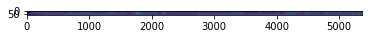

In [4]:
plt.imshow(data["data"])

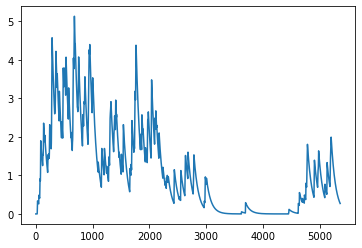

In [5]:
plt.plot(data["data"][0,: ])

In [8]:
data = loadmat('./data/n10612_6_230423_t162213_C.mat')
input_ = np.array(data["data"], dtype=np.float64)
x = sum_chunk(input_, 100)
cov_mat = np.corrcoef(x)

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [9]:
cov_mat.shape

(60, 60)

In [121]:
def loss_function(theta, data):
    loss = np.trace(theta @ data) - np.linalg.slogdet(theta)[1]
    return loss


def gradient(theta, data):
    # Compute the inverse of the covariance matrix
    inv_theta = np.linalg.inv(theta)
    # print(f'shape of inv_theta: {inv_theta.shape}')
    # print(f'shape of data: {data.shape}')
    
    # Compute the gradient
    gradient_matrix = - inv_theta + data
    
    return gradient_matrix


In [122]:

true_cov = np.array([[0.8, 0.0, 0.2, 0.0],
                     [0.0, 0.4, 0.0, 0.0],
                     [0.2, 0.0, 0.3, 0.1],
                     [0.0, 0.0, 0.1, 0.7]])
np.random.seed(0)
X = np.random.multivariate_normal(mean=[0, 0, 0, 0],
                                  cov=true_cov,
                                  size=1000)
cov = GraphicalLasso(alpha=0.1).fit(X)
np.around(cov.covariance_, decimals=3)

array([[0.764, 0.   , 0.111, 0.   ],
       [0.   , 0.387, 0.   , 0.   ],
       [0.111, 0.   , 0.306, 0.   ],
       [0.   , 0.   , 0.   , 0.652]])

In [146]:
cov_mat = np.cov(X.T)

f = lambda x: loss_function(x, cov_mat)
grad = lambda x: gradient(x, cov_mat)

tau = 1
prox = lambda x, t: np.sign(x) * np.maximum(0, np.fabs(x) - tau * t)
prox_fcn = lambda x: tau * norm(x, ord=1)

estimated_cov, _ = gradientDescent(
    f,
    grad,
    x0=np.random.randn(cov_mat.shape[0], cov_mat.shape[1]),
    prox=prox,
    prox_obj=prox_fcn,
    saveHistory=True,
    linesearch=True,
    stepsizeOptimism=0.9,
    tol=1e-6,
    maxIters=1e4,
)

Iter.  Objective Stepsize
-----  --------- --------
    0  5.79e+00  2.03e-02
   92  4.56e+00  1.39e-06
==  Quitting due to stagnating objective value  ==


In [139]:
estimated_cov.shape

(4, 4)

In [141]:
estimated_cov @ np.linalg.inv(estimated_cov)

array([[ 1.00000000e+00, -4.44089210e-16,  1.38777878e-17,
         2.22044605e-16],
       [ 1.98558348e-17,  1.00000000e+00,  0.00000000e+00,
        -3.17693356e-17],
       [-2.77555756e-17,  2.22044605e-16,  1.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00, -1.11022302e-16,  0.00000000e+00,
         1.00000000e+00]])

In [142]:
np.around(np.linalg.inv(estimated_cov), decimals=3)


array([[-0.081, -0.369,  0.021, -0.324],
       [-0.   , -0.204,  0.   ,  0.   ],
       [-0.018,  0.29 , -0.227,  0.28 ],
       [-0.159,  0.971,  0.041,  0.73 ]])

In [147]:
np.around(estimated_cov, decimals=3)


array([[ 1.463, -0.12 ,  0.54 ,  0.435],
       [-0.53 ,  0.299, -0.057, -0.52 ],
       [-0.759, -1.948, -1.954, -0.012],
       [ 0.258,  0.157, -0.866,  1.5  ]])

In [76]:
cov.precision_

array([[ 1.38277995,  0.        , -0.50438699,  0.        ],
       [ 0.        ,  2.58627583, -0.        , -0.        ],
       [-0.50438699, -0.        ,  3.4570336 , -0.        ],
       [ 0.        , -0.        , -0.        ,  1.53448034]])

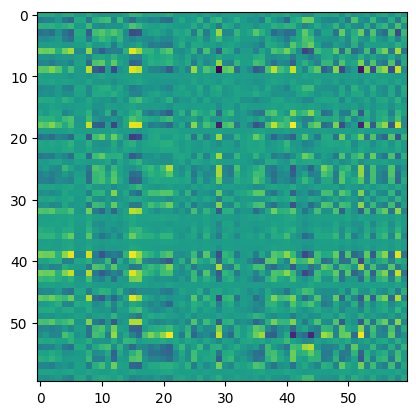

In [215]:
plt.imshow(dual)

In [49]:
loss_function(np.random.randn(60, 60), data)

-94.59993884281177

In [18]:
cov_mat

array([[ 1.        ,  0.89669635,  0.89808317, ..., -0.76067556,
         0.68685239, -0.62768009],
       [ 0.89669635,  1.        ,  0.9216486 , ..., -0.77588167,
         0.75568961, -0.75716372],
       [ 0.89808317,  0.9216486 ,  1.        , ..., -0.87978793,
         0.80636822, -0.61615451],
       ...,
       [-0.76067556, -0.77588167, -0.87978793, ...,  1.        ,
        -0.71165047,  0.45004161],
       [ 0.68685239,  0.75568961,  0.80636822, ..., -0.71165047,
         1.        , -0.49776238],
       [-0.62768009, -0.75716372, -0.61615451, ...,  0.45004161,
        -0.49776238,  1.        ]])

In [38]:
cov.precision_

array([[ 6.34152897e+00, -1.03063887e+00, -1.00745974e+00, ...,
         0.00000000e+00,  0.00000000e+00, -0.00000000e+00],
       [-1.03063887e+00,  7.64259897e+00, -1.49249018e+00, ...,
         0.00000000e+00, -4.68487239e-03,  5.49659244e-01],
       [-1.00745974e+00, -1.49249018e+00,  1.31685066e+01, ...,
         0.00000000e+00, -0.00000000e+00,  0.00000000e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         1.10885386e+01, -0.00000000e+00, -0.00000000e+00],
       [ 0.00000000e+00, -4.68487239e-03, -0.00000000e+00, ...,
        -0.00000000e+00,  4.45994069e+00,  0.00000000e+00],
       [-0.00000000e+00,  5.49659244e-01,  0.00000000e+00, ...,
        -0.00000000e+00,  0.00000000e+00,  5.85222911e+00]])

In [35]:
cov = GraphicalLasso(alpha=0.05, mode="cd", covariance="precomputed", max_iter=int(1e3)).fit(cov_mat)
np.around(cov.covariance_, decimals=3)

/home/tzuchi/.cache/pypoetry/virtualenvs/functional-connectivity-Av9PpV25-py3.10/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:183: ConvergenceWarning: graphical_lasso: did not converge after 1000 iteration: dual gap: -9.580e-02
  warnings.warn(


array([[ 1.   ,  0.847,  0.848, ..., -0.746,  0.707, -0.632],
       [ 0.847,  1.   ,  0.872, ..., -0.746,  0.706, -0.707],
       [ 0.848,  0.872,  1.   , ..., -0.841,  0.769, -0.598],
       ...,
       [-0.746, -0.746, -0.841, ...,  1.   , -0.725,  0.441],
       [ 0.707,  0.706,  0.769, ..., -0.725,  1.   , -0.462],
       [-0.632, -0.707, -0.598, ...,  0.441, -0.462,  1.   ]])

In [27]:
np.linalg.inv(cov.covariance_)[0, :]

array([ 6.34082217e+00, -1.03111658e+00, -1.00783374e+00, -3.69406797e-04,
       -6.60769136e-01, -3.42809563e-04, -3.32890793e-04,  5.69974725e-04,
       -4.10969744e-04, -6.06262885e-04,  2.54843473e-04,  1.66435649e-04,
        3.79973734e-04, -9.46721798e-02, -1.46551827e-04,  4.70912292e-04,
       -1.39993954e+00, -4.58765815e-05,  4.94750019e-02, -2.71022713e-04,
       -2.61794682e-04,  3.71490278e-04, -2.84869100e-04,  1.33341089e-05,
        1.21745613e-04, -4.36472950e-04, -1.59665104e-04, -5.14712220e-01,
        2.00215569e-04, -3.85304243e-04,  2.31581592e-04, -1.02512051e+00,
        3.28418532e-04, -7.40656260e-05,  6.19367733e-05,  2.63271000e-04,
       -4.72213717e-04,  2.13195077e-06,  3.47587125e-04, -1.01383575e+00,
       -8.76719115e-01, -6.38634608e-05,  7.08609828e-05,  2.75055516e-04,
        1.45998156e-05, -3.01424988e-05,  1.41831569e-04, -1.64259793e-01,
       -1.51403690e-01,  3.21289979e-05, -2.41402068e-01,  1.96205254e-05,
        1.02519214e-04, -

In [50]:
gradient(np.random.randn(60, 60), data).shape

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 5362 is different from 60)

array([[0.816, 0.   , 0.   , 0.   ],
       [0.   , 0.364, 0.   , 0.   ],
       [0.   , 0.   , 0.322, 0.   ],
       [0.   , 0.   , 0.   , 0.69 ]])

In [40]:
cov.precision_

array([[ 1.22596272, -0.        , -0.        , -0.        ],
       [-0.        ,  2.74605582, -0.        , -0.        ],
       [-0.        , -0.        ,  3.10477899, -0.        ],
       [-0.        , -0.        , -0.        ,  1.44860969]])

In [47]:
np.linalg.inv(estimated_cov)

array([[-6.35959861e+06, -1.10596374e+07, -7.58678370e+06,
        -3.70358992e+06],
       [-0.00000000e+00,  9.94546107e-03, -0.00000000e+00,
        -0.00000000e+00],
       [ 8.64837964e+06,  1.50399339e+07,  1.03172212e+07,
         5.03648950e+06],
       [-6.41765371e+06, -1.11605979e+07, -7.65604146e+06,
        -3.73739902e+06]])

In [284]:
np.around(np.linalg.inv(estimated_cov), decimals=3)

array([[ 1.05700000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.52972917e+06, -2.44861124e+09, -7.27042399e+05,
        -1.19518910e+07],
       [ 0.00000000e+00,  0.00000000e+00,  3.09800000e+00,
         0.00000000e+00],
       [ 3.84460338e+07,  6.15399091e+10,  1.82724472e+07,
         3.00381822e+08]])

In [286]:
np.around(estimated_cov, decimals=3)


array([[ 9.46e-01,  0.00e+00,  0.00e+00,  0.00e+00],
       [-2.00e-03, -1.80e-02, -0.00e+00, -1.00e-03],
       [ 0.00e+00,  0.00e+00,  3.23e-01,  0.00e+00],
       [ 2.17e-01,  3.79e+00,  7.00e-02,  1.51e-01]])

In [218]:
np.around(cov.location_, decimals=3)

array([0.073, 0.04 , 0.038, 0.143])

In [227]:
sigs = np.load('./playground/GLASSO_Framework/db/GLASSO/N20_random10.0_Iadd0.1_samples100-100_Normal_id0/Sigs.npy')
ss = np.load('./playground/GLASSO_Framework/db/GLASSO/N20_random10.0_Iadd0.1_samples100-100_Normal_id0/Ss.npy')
ys = np.load('./playground/GLASSO_Framework/db/GLASSO/N20_random10.0_Iadd0.1_samples100-100_Normal_id0/ys.npy')

In [228]:
ss.shape

(1, 20, 20)

In [229]:
ys.shape

(1, 20, 100)

In [230]:
sigs.shape

(1, 20, 20)

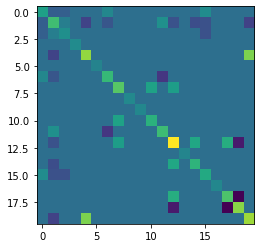

In [233]:
plt.imshow(sigs[0, :, :])

In [258]:
cov = GraphicalLassoCV(assume_centered=True, mode="lars").fit(ys[0, :, :].T)
np.around(cov.covariance_, decimals=3)

/home/tzuchi/.local/lib/python3.10/site-packages/sklearn/linear_model/_least_angle.py:776: RuntimeWarning: overflow encountered in multiply
  Cov -= gamma_ * corr_eq_dir
/home/tzuchi/.local/lib/python3.10/site-packages/numpy/core/_methods.py:232: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/home/tzuchi/.local/lib/python3.10/site-packages/sklearn/covariance/_graph_lasso.py:316: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: 4.802e-02
  warnings.warn(


array([[ 1.   , -0.068, -0.116, -0.016,  0.048, -0.124, -0.602,  0.052,
        -0.   , -0.129, -0.07 , -0.349, -0.061,  0.05 ,  0.056, -0.423,
         0.031, -0.044, -0.083, -0.063],
       [-0.068,  1.   ,  0.072,  0.053,  0.301, -0.037, -0.081, -0.035,
         0.026,  0.052,  0.038, -0.51 ,  0.071,  0.044,  0.295,  0.461,
        -0.042, -0.106, -0.063,  0.083],
       [-0.116,  0.072,  1.   ,  0.071,  0.144,  0.201,  0.042, -0.002,
         0.087,  0.077,  0.011, -0.018,  0.043, -0.007, -0.061,  0.427,
         0.103, -0.037,  0.001, -0.122],
       [-0.016,  0.053,  0.071,  1.   , -0.004,  0.055, -0.05 , -0.041,
         0.066, -0.056,  0.036, -0.047,  0.063,  0.028, -0.057,  0.123,
         0.071,  0.011,  0.055,  0.039],
       [ 0.048,  0.301,  0.144, -0.004,  1.   ,  0.014, -0.139, -0.032,
         0.143,  0.065,  0.041, -0.299,  0.038,  0.028,  0.101,  0.161,
         0.004, -0.24 , -0.183, -0.73 ],
       [-0.124, -0.037,  0.201,  0.055,  0.014,  1.   ,  0.073,  0.07 ,
   

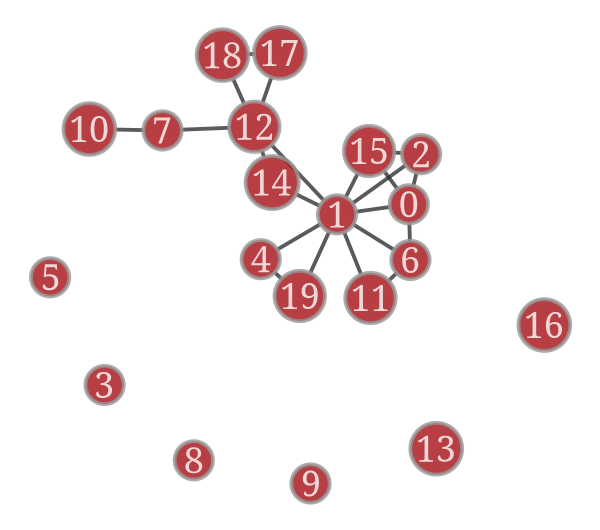

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f7f740975b0, at 0x7f7f692c7a00>

In [256]:
d = sigs
edgelist = []
for ind_i, i in enumerate(d[0, :, :]):
    for ind_j, j in enumerate(d[0, :, :][ind_i]):
        if ind_i != ind_j and j != 0:
            if (ind_i, ind_j) not in edgelist:
                edgelist.append((ind_j, ind_i))
g = gt.Graph(directed=False)
g.add_edge_list(edgelist)
gt.graph_draw(g, vertex_text=g.vertex_index, vertex_font_size=18, output_size=(300, 300))

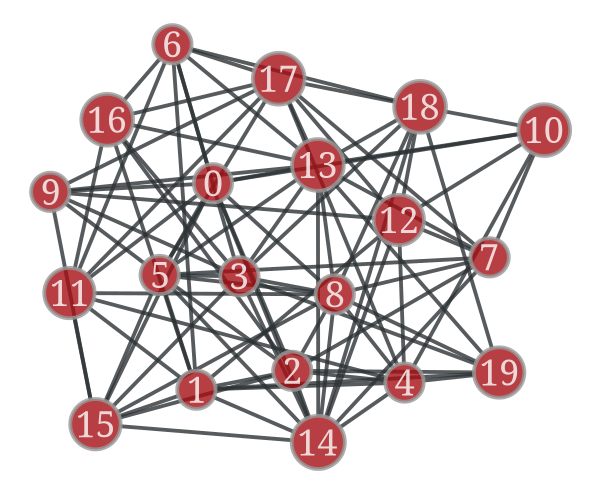

<VertexPropertyMap object with value type 'vector<double>', for Graph 0x7f7f692c7940, at 0x7f7f692c7c40>

In [259]:
d = cov.precision_
edgelist = []
for ind_i, i in enumerate(d[:, :]):
    for ind_j, j in enumerate(d[:, :][ind_i]):
        if ind_i != ind_j and j != 0:
            if (ind_i, ind_j) not in edgelist:
                edgelist.append((ind_j, ind_i))
g = gt.Graph(directed=False)
g.add_edge_list(edgelist)
gt.graph_draw(g, vertex_text=g.vertex_index, vertex_font_size=18, output_size=(300, 300))

In [238]:
d[9,:]

array([ 0.08110151, -0.        , -0.        ,  0.0646973 , -0.        ,
       -0.05429112, -0.01798836, -0.        ,  0.00814188,  1.0780762 ,
        0.        ,  0.0157759 ,  0.18256864, -0.03655472, -0.        ,
       -0.1401312 ,  0.00125734,  0.10248404,  0.        ,  0.04189738],
      dtype=float32)

In [3]:
gg = GraphicalGenerator(20, "random", 0.1, 100)

In [5]:
gg()

([array([[1.0417919 , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.8871939 , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.89666295, 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ],
         [0.        , 0.        , 0.        , 1.0378423 , 0.        ,
          0.        , 0.        , 0.        , 0.        , 0.        ,
          0.     